# 1D EULER SYSTEM SOLVER

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## IMPLEMENTATION

In [8]:
class solver:
    
    def __init__(self, a, b, n_cells, gamma = 5.0 / 3.0):
        self.x = np.linspace(a, b, n_cells + 1)            # grid nodes
        self.u = np.zeros(n_cells + 1)                     # velocity
        self.rho = np.zeros(n_cells)                       # density
        self.p = np.zeros(n_cells)                         # pressure
        self.E = np.zeros(n_cells)                         # energy
        self.q = np.zeros(n_cells)                         # artificial viscosity
        self.L = np.zeros(n_cells + 1)                     # laser energy flux
        self.gamma = gamma                                 # adiabatic index (ratio of specific heats)
        self.laser = None                                  # laser datastructure
        self.atomic_weight = 0.0                           # standard atomic weight
        
    def set_gamma(self, gamma):
        self.gamma = gamma
        
    class laser():
        
        def __init__(self, wavelength, intensity, t_0, fwhm):
            self.wavelength = wavelength                   # laser wavelength
            self.intensity = intensity                     # laser peak vacuum intensity
            self.t_0 = t_0                                 # time at which laser reaches peak intensity
            self.fwhm = fwhm                               # laser duration at FWHM 
            
        def evaluate_laser(self, t):
            return self.intensity * np.exp(-(t - self.t_0)**2 / (self.fwhm / np.sqrt(2.0 * np.log(2.0)))**2)
        
    def set_laser(self, wavelength, intensity, t_0, fwhm):
        self.laser = solver.laser(wavelength, intensity, t_0, fwhm)
        
    def set_atomic_weight(self, atomic_weight):
        self.atomic_weight = atomic_weight
        
    def calculate_critical_density(self):
        return 1.8513e-09 * self.atomic_weight / (self.laser.wavelength)**2
        
    def initialize_riemann_problem(self, variable, interface, init_values):
        indices = [0, variable.size]
        for x_0 in interface:
            indices.insert(-1, self.x[self.x <= x_0].size)          
        for i in range(len(indices)-1):
            values = np.asarray(init_values[i])
            if values.size == 1:
                variable[indices[i]:indices[i+1]] = values
            else:
                variable[indices[i]:indices[i+1]] = values[indices[i]:indices[i+1]]
        
    def run(self, t_start, t_end, CFL = 0.25, c_a = 0.5, c_1 = 1.0, c_2 = 1.0):
        t = t_start   
    
        # initialize energy using the equation of state for ideal gas:
        self.E = self.p / (self.rho * (self.gamma - 1))
        
        u_new = np.copy(self.u)
        
        # simulation loop:
        while(t <= t_end):

            # update cell volume:
            V = self.x[1:] - self.x[:-1]

            # update cell mass:
            m = self.rho * V

            # calculate speed of sound:
            u_s = np.sqrt((self.gamma - 1) * self.gamma * self.E)

            # calculate timestep:
            dt = CFL * np.min(V / u_s)

            # calculate artificial viscosity:
            self.q.fill(0.0)
            for i in range(1, self.q.size - 1):
                if self.u[i+1] >= self.u[i]:
                    self.q[i] = 0.0
                else:
                    r_l = (V[i] * (self.u[i+2] - self.u[i+1])) / (V[i+1] * (self.u[i+1] - self.u[i]))
                    r_r = (V[i] * (self.u[i] - self.u[i-1])) / (V[i-1] * (self.u[i+1] - self.u[i]))
                    phi = max(0.0, min(0.5 * (r_l + r_r), 2.0 * r_l, 2.0 * r_r, 1.0))
                    q_kur = self.rho[i] * np.abs(self.u[i+1] - self.u[i]) * (c_2 * (self.gamma + 1.0) / 4.0 \
                            * np.abs(self.u[i+1] - self.u[i]) + np.sqrt((c_2 * (self.gamma + 1.0) / 4.0 \
                            * (self.u[i+1] - self.u[i]))**2 + (c_1 * u_s[i])**2))
                    self.q[i] = q_kur * (1.0 - phi) 

            # update velocity:
            u_new[1:-1] = self.u[1:-1] - 2.0 * dt * (self.p[1:] - self.p[:-1] + self.q[1:] - self.q[:-1]) \
                          / (m[1:] + m[:-1])

            # update grid nodes:
            x_new = self.x + dt * (u_new + self.u) / 2.0
            
            # calculate absorption of laser pulse:
            if self.laser != None:
                rho_critical = np.argwhere(self.rho > self.calculate_critical_density())
                if rho_critical.size == 0:
                    self.L[:] = -c_a * self.laser.evaluate_laser(t)
                else:
                    self.L[0:rho_critical[-1][0]+1] = 0.0
                    self.L[rho_critical[-1][0]+1:self.L.size] = -c_a * self.laser.evaluate_laser(t)

            # update energy:
            E_new = self.E - 0.5 * dt / m * (self.p + self.q) * (u_new[1:] - u_new[:-1] + self.u[1:] - self.u[:-1] \
                    - self.L[1:] + self.L[:-1])

            # update density:
            rho_new = m / (x_new[1:] - x_new[:-1])             

            # update pressure:
            p_new = E_new * rho_new * (self.gamma - 1)

            # assign new values to old ones:
            self.u = u_new
            self.x = x_new
            self.E = E_new
            self.rho = rho_new
            self.p = p_new

            # update time:
            t += dt
            
    def plot(self, variable, name = "", centered = False):
        fig, ax = plt.subplots()
        xx = (self.x[1:] + self.x[:-1]) / 2.0 if centered else x
        ax.plot(xx, variable)
        ax.set_xlabel("x")
        ax.set_ylabel(name)

## EXAMPLES

### Riemann problem 1:

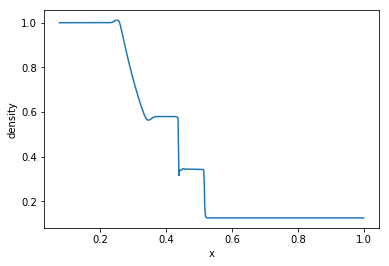

In [3]:
s = solver(a = 0.0, b = 1.0, n_cells = 400, gamma = 1.4)
s.initialize_riemann_problem(s.p, interface = [0.3], init_values = [1.0, 0.1])
s.initialize_riemann_problem(s.rho, interface = [0.3], init_values = [1.0, 0.125])
s.initialize_riemann_problem(s.u, interface = [0.3], init_values = [0.75, 0.0])
s.run(t_start = 0.0, t_end = 0.1)
s.plot(s.rho, name = "density", centered = True)

### Riemann problem 2:

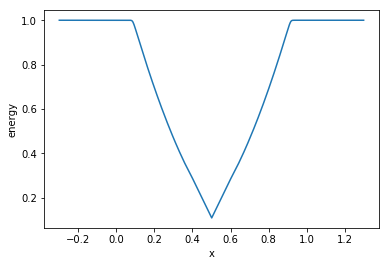

In [4]:
s = solver(a = 0.0, b = 1.0, n_cells = 400, gamma = 1.4)
s.initialize_riemann_problem(s.p, interface = [], init_values = [0.4])
s.initialize_riemann_problem(s.rho, interface = [], init_values = [1.0])
s.initialize_riemann_problem(s.u, interface = [0.5], init_values = [-2.0, 2.0])
s.run(t_start = 0.0, t_end = 0.15)
s.plot(s.E, name = "energy", centered = True)

### Woodward-Collela (blast wave):

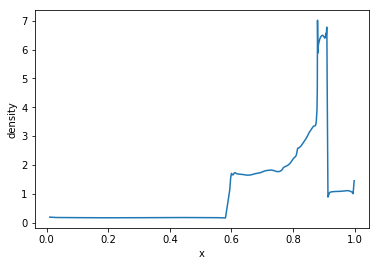

In [5]:
s = solver(a = 0.0, b = 1.0, n_cells = 250, gamma = 1.4)
s.initialize_riemann_problem(s.p, interface = [0.1, 0.9], init_values = [1000.0, 0.01, 100.0])
s.initialize_riemann_problem(s.rho, interface = [], init_values = [1.0])
s.initialize_riemann_problem(s.u, interface = [], init_values = [0.0])
s.run(t_start = 0.0, t_end = 1.8)
s.plot(s.rho, name = "density", centered = True)

### Shu-Osher (entropy shock wave):

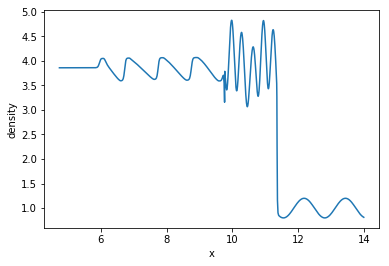

In [6]:
s = solver(a = 0.0, b = 14.0, n_cells = 725, gamma = 1.4)
s.initialize_riemann_problem(s.p, interface = [5.0], init_values = [10.33333, 1.0])
s.initialize_riemann_problem(s.rho, interface = [5.0], init_values = [3.857143, 1.0 + 0.2 * np.sin(5.0 * s.x - 9.0)])
s.initialize_riemann_problem(s.u, interface = [5.0], init_values = [2.629369, 0.0])
s.run(t_start = 0.0, t_end = 1.8)
s.plot(s.rho, name = "density", centered = True)

### Laser-plasma interaction:

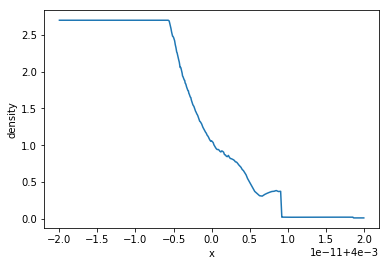

In [9]:
s = solver(a = (40.0e-4 - 0.2e-10), b = (40.0e-4 + 0.2e-10), n_cells = 1000, gamma = 5.0 / 3.0)
s.initialize_riemann_problem(s.p, interface = [40.0e-4], init_values = [1.0, 0.01])
s.initialize_riemann_problem(s.rho, interface = [40.0e-4], init_values = [2.7, 0.01])
s.initialize_riemann_problem(s.u, interface = [40.0e-4], init_values = [0.0, 0.0])
s.set_laser(wavelength = 1.315e-4, intensity = 1.0e15, t_0 = 4.0e-12, fwhm = 4.0e-12)
s.set_atomic_weight(26.98)
s.run(t_start = 0.0, t_end = 8.0e-12, CFL = 0.19, c_a = 0.5)
s.plot(s.rho, name = "density", centered = True)